# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
#from matplotlib_venn import venn2
import pandas_datareader # install with `pip install pandas-datareader`
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`
pd.set_option('display.float_format', lambda x: '%.2f' % x) # formating
from matplotlib.dates import date2num

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

**We import data from Statistics Denmark regarding production divided between industries and data regarding the effective exchange rate of the DKK**

In [110]:
GDP = DstApi('NKBP10')
exrate = DstApi('DNVALQ') 

# a. Tables of the variables
tabsum_GDP = GDP.tablesummary(language='en')
display(tabsum_GDP)
tabsum_exrate = exrate.tablesummary(language='en')
display(tabsum_exrate)


Table NKBP10: 1-2.1.1 Production
and  generation of income (10a3-grouping) by transaction, industry, price unit, seasonal adjustment and time
Last update: 2023-03-31T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TRANSAKT,7,P1K,P.1 Output,B2A3GD,B.2g+B.3g Gross operating surplus and mixed in...,False
1,BRANCHE,15,V,Total,VR_S,"R_S Arts, entertainment and other services",False
2,PRISENHED,2,V,Current prices,LKV,"2010-prices, chained values",False
3,SÆSON,2,N,Non-seasonally adjusted,Y,Seasonally adjusted,False
4,Tid,132,1990K1,1990Q1,2022K4,2022Q4,True


Table DNVALQ: Quarterly exchange rates by currency, type, methodology and time
Last update: 2023-03-30T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,VALUTA,2,DKK,Nominal effective Krone rate (Jan. 1970-),X00,All currencies - excl. Danish kroner,False
1,KURTYP,4,INX,"Index (only nominal effective krone rate), ind...",RET,Real effective krone rate based on hourly earn...,False
2,OPGOER,3,A,Quarterly average,Y,Annual growth rate,False
3,Tid,212,1970K1,1970Q1,2022K4,2022Q4,True


## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

In [111]:
# The available values for a each variable in GDP dataset: 
for variable in tabsum_GDP['variable name']:
    print(variable+':')
    display(GDP.variable_levels(variable, language='en'))

TRANSAKT:


,id,text
0,P1K,P.1 Output
1,P2D,P.2 Intermediate consumption
2,B1GD,B.1g Gross value added
3,D29X39D,D.29-D.39 Other taxes less subsidies on produc...
4,B1GFD,B.1GF Gross domestic product at factor cost
5,D1D,D.1 Compensation of employees
6,B2A3GD,B.2g+B.3g Gross operating surplus and mixed in...


BRANCHE:


,id,text
0,V,Total
1,VMEMO,Of which: General government
2,VA,"A Agriculture, forestry and fishing"
3,VB,B Mining and quarrying
4,VC,C Manufacturing
5,VD_E,D_E Utility services
6,VF,F Construction
7,VG_I,G_I Trade and transport etc.
8,VJ,J Information and communication
9,VK,K Financial and insurance


PRISENHED:


,id,text
0,V,Current prices
1,LKV,"2010-prices, chained values"


SÆSON:


,id,text
0,N,Non-seasonally adjusted
1,Y,Seasonally adjusted


Tid:


,id,text
0,1990K1,1990Q1
1,1990K2,1990Q2
2,1990K3,1990Q3
3,1990K4,1990Q4
4,1991K1,1991Q1
...,...,...
127,2021K4,2021Q4
128,2022K1,2022Q1
129,2022K2,2022Q2
130,2022K3,2022Q3


In [112]:
# The available values for each variable in exchange rate dataset: 
for variable in tabsum_exrate['variable name']:
    print(variable+':')
    display(exrate.variable_levels(variable, language='en'))

VALUTA:


,id,text
0,DKK,Nominal effective Krone rate (Jan. 1970-)
1,X00,All currencies - excl. Danish kroner


KURTYP:


,id,text
0,INX,"Index (only nominal effective krone rate), ind..."
1,LOI,"Hourly earnings in manufacturing in Denmark, s..."
2,LOU,Weighted hourly earnings in manufacturing abro...
3,RET,Real effective krone rate based on hourly earn...


OPGOER:


,id,text
0,A,Quarterly average
1,B,Calculated
2,Y,Annual growth rate


Tid:


,id,text
0,1970K1,1970Q1
1,1970K2,1970Q2
2,1970K3,1970Q3
3,1970K4,1970Q4
4,1971K1,1971Q1
...,...,...
207,2021K4,2021Q4
208,2022K1,2022Q1
209,2022K2,2022Q2
210,2022K3,2022Q3


**Defining parameters, joining and filtering data**

In [113]:
# a. define parameters
params_GDP = GDP._define_base_params(language='en')
params_exrate = exrate._define_base_params(language='en')

# b. load api
GDP_api = GDP.get_data(params=params_GDP)
exrate_api = exrate.get_data(params=params_exrate)

In [163]:
# a. left join data by TID
api_inner = pd.merge(GDP_api, exrate_api, on='TID', how='left')
api_inner.rename(columns = {'INDHOLD_x':'INDHOLD_GDP', 'INDHOLD_y':'INDHOLD_exrate'}, inplace=True)

# b. filter data
I = api_inner.TRANSAKT.str.contains('P.1')
# I |= api_inner.TRANSAKT.str.contains('D.29-D.39')
# I |= api_inner.TRANSAKT.str.contains('D.1')
I &= api_inner.PRISENHED.str.contains('Current prices')
I &= api_inner.SÆSON.str.contains('Seasonally adjusted')
I &= api_inner.VALUTA.str.contains('Nominal effective')
I &= api_inner.KURTYP.str.contains('Index')
I &= api_inner.OPGOER.str.contains('Quarterly')
I &= api_inner.TID.str.contains('Q1')
api_inner.loc[I, :]
api_inner = api_inner.loc[I == True]

# c. new indexing and atomic types
api_inner.reset_index(inplace = True, drop = True)
api_inner = api_inner.apply(pd.to_numeric, errors='ignore')
api_inner['TID'] = api_inner['TID'].apply(pd.to_datetime, errors='ignore')
api_inner

,TRANSAKT,BRANCHE,PRISENHED,SÆSON,TID,INDHOLD_GDP,VALUTA,KURTYP,OPGOER,INDHOLD_exrate
0,P.1 Output,Total,Current prices,Seasonally adjusted,2016-01-01,894048,Nominal effective Krone rate (Jan. 1970-),"Index (only nominal effective krone rate), ind...",Quarterly average,100.21
1,P.1 Output,"A Agriculture, forestry and fishing",Current prices,Seasonally adjusted,2016-01-01,19179,Nominal effective Krone rate (Jan. 1970-),"Index (only nominal effective krone rate), ind...",Quarterly average,100.21
2,P.1 Output,B Mining and quarrying,Current prices,Seasonally adjusted,2016-01-01,6223,Nominal effective Krone rate (Jan. 1970-),"Index (only nominal effective krone rate), ind...",Quarterly average,100.21
3,P.1 Output,C Manufacturing,Current prices,Seasonally adjusted,2016-01-01,177829,Nominal effective Krone rate (Jan. 1970-),"Index (only nominal effective krone rate), ind...",Quarterly average,100.21
4,P.1 Output,D_E Utility services,Current prices,Seasonally adjusted,2016-01-01,21661,Nominal effective Krone rate (Jan. 1970-),"Index (only nominal effective krone rate), ind...",Quarterly average,100.21
...,...,...,...,...,...,...,...,...,...,...
490,P.1 Output,LA Real estate activities and renting of non-r...,Current prices,Seasonally adjusted,2006-01-01,14595,Nominal effective Krone rate (Jan. 1970-),"Index (only nominal effective krone rate), ind...",Quarterly average,100.86
491,P.1 Output,D_E Utility services,Current prices,Seasonally adjusted,2001-01-01,14820,Nominal effective Krone rate (Jan. 1970-),"Index (only nominal effective krone rate), ind...",Quarterly average,97.01
492,P.1 Output,D_E Utility services,Current prices,Seasonally adjusted,2002-01-01,15411,Nominal effective Krone rate (Jan. 1970-),"Index (only nominal effective krone rate), ind...",Quarterly average,96.90
493,P.1 Output,D_E Utility services,Current prices,Seasonally adjusted,2003-01-01,16080,Nominal effective Krone rate (Jan. 1970-),"Index (only nominal effective krone rate), ind...",Quarterly average,100.06


# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

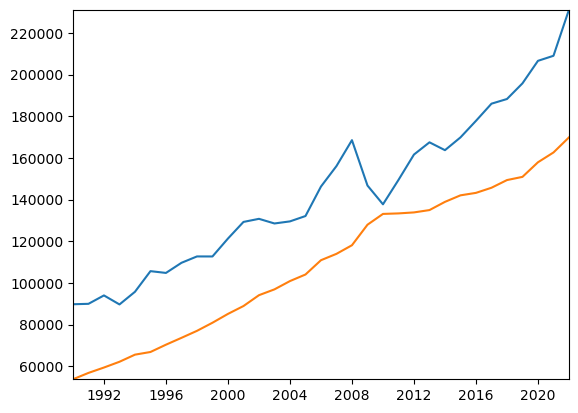

In [164]:
api_inner = api_inner.sort_values(by='TID',ascending=True)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
man_plot = api_inner.loc[api_inner.BRANCHE.str.contains('Manufacturing') == True]
gov_plot = api_inner.loc[api_inner.BRANCHE.str.contains('Public administration, education and health') == True]

ax.plot(man_plot['TID'],man_plot['INDHOLD_GDP'])
ax.plot(gov_plot['TID'],gov_plot['INDHOLD_GDP'],scalex=True)
ax.margins(0,0)

C:\Users\jacob\AppData\Local\Temp\ipykernel_11776\2444585670.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  man_plot['Diff'] = man_plot['INDHOLD_GDP'].diff(periods=1)
C:\Users\jacob\AppData\Local\Temp\ipykernel_11776\2444585670.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gov_plot['Diff'] = gov_plot['INDHOLD_GDP'].diff(periods=1)


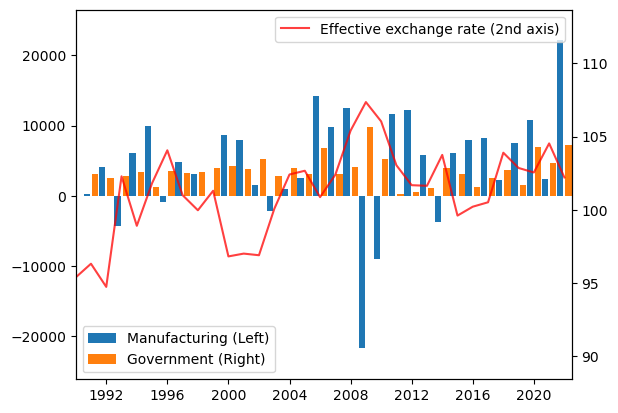

In [224]:
man_plot['Diff'] = man_plot['INDHOLD_GDP'].diff(periods=1)
gov_plot['Diff'] = gov_plot['INDHOLD_GDP'].diff(periods=1)

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax2 = ax1.twinx()
ax1.bar(height=man_plot['Diff'],x=date2num(man_plot['TID'])-100,width=150,label='Manufacturing (Left)')
ax1.bar(height=gov_plot['Diff'],x=date2num(gov_plot['TID'])+100,width=150,label='Government (Right)')
ax2.plot(date2num(man_plot['TID']),man_plot['INDHOLD_exrate'],color='red',alpha=0.75, label='Effective exchange rate (2nd axis)')
ax1.xaxis_date()
ax1.legend(loc=0)
ax2.legend(loc=0)
ax1.margins(0,0.1)
ax2.margins(0,0.5)

In [116]:
api_inner.describe()

,INDHOLD_GDP,INDHOLD_exrate
count,1980.00,1980.00
mean,101093.56,101.25
std,181589.36,3.08
min,2200.00,93.53
25%,18589.75,99.45
50%,39272.50,101.71
75%,103202.25,103.23
max,1350207.00,108.35


Summary statistics grouped by industries

In [117]:
api_branche = api_inner.groupby(by=['TID','BRANCHE'])['INDHOLD_GDP'].describe()
# api_branche = api_inner.groupby(by='BRANCHE')['INDHOLD_GDP'].describe()
# api_branche = api_branche.sort_values(by='mean',ascending=False)
# api_branche = api_branche.head(5)
api_branche = api_branche['mean']
# I = api_branche.BRANCHE.str.contains('A')
# api_branche.loc[I, :]
# api_branche = api_branche.loc[I == True]
api_branche
# type(api_branche)


TID         BRANCHE                                        
1990-01-01  A Agriculture, forestry and fishing                 16113.00
            B Mining and quarrying                               2412.00
            C Manufacturing                                     89793.00
            D_E Utility services                                 8489.00
            F Construction                                      25691.00
                                                                 ...    
2022-10-01  M_N Other business services                        115522.00
            O_Q Public administration, education and health    172574.00
            Of which: General government                       170546.00
            R_S Arts, entertainment and other services          28917.00
            Total                                             1334131.00
Name: mean, Length: 1980, dtype: float64

In [118]:
api_branche = api_branche.filter(like='Agriculture')
api_branche = api_branche.dataframe()
api_branche 


AttributeError: 'Series' object has no attribute 'dataframe'

**Plots of our data**

In [ ]:

api_branche.plot(kind='line',x='TID',xlabel='Tid',)

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.